In [1]:
import pandas as pd
import numpy as np
import seaborn as sbs
import matplotlib.pyplot as plt

In [2]:
input_csv = "../results/math.csv"
baseline = "x86_64,qemu,qemu"
base_arch, base_runtime, base_tag = baseline.split(',')
df = pd.read_csv(input_csv, sep=';')
df

,arch,bench,cmdline,dataset,threads,unit,value,retval,runtime,tag
0,aarch64,micro.math-sqrt,build/math-bins/math.aarch64,none,1.0,ops/ms,144981.180950,0,native,native
1,aarch64,micro.math-sin,build/math-bins/math.aarch64,none,1.0,ops/ms,4902.127136,0,native,native
2,aarch64,micro.math-cos,build/math-bins/math.aarch64,none,1.0,ops/ms,4887.191686,0,native,native
3,aarch64,micro.math-tan,build/math-bins/math.aarch64,none,1.0,ops/ms,3850.523680,0,native,native
4,aarch64,micro.math-asin,build/math-bins/math.aarch64,none,1.0,ops/ms,30556.670315,0,native,native
...,...,...,...,...,...,...,...,...,...,...
76,x86_64,micro.math-asin,build/math-bins/math.x86_64,none,1.0,ops/ms,10261.891797,0,qemu,risotto
77,x86_64,micro.math-acos,build/math-bins/math.x86_64,none,1.0,ops/ms,10263.160492,0,qemu,risotto
78,x86_64,micro.math-atan,build/math-bins/math.x86_64,none,1.0,ops/ms,10102.113906,0,qemu,risotto
79,x86_64,micro.math-exp,build/math-bins/math.x86_64,none,1.0,ops/ms,13981.582722,0,qemu,risotto


In [3]:
base_df = df.loc[df['tag'] == 'qemu']
base_df

,arch,bench,cmdline,dataset,threads,unit,value,retval,runtime,tag
27,x86_64,micro.math-sqrt,build/math-bins/math.x86_64,none,1.0,ops/ms,27283.864861,0,qemu,qemu
28,x86_64,micro.math-sin,build/math-bins/math.x86_64,none,1.0,ops/ms,383.262026,0,qemu,qemu
29,x86_64,micro.math-cos,build/math-bins/math.x86_64,none,1.0,ops/ms,378.406724,0,qemu,qemu
30,x86_64,micro.math-tan,build/math-bins/math.x86_64,none,1.0,ops/ms,308.092364,0,qemu,qemu
31,x86_64,micro.math-asin,build/math-bins/math.x86_64,none,1.0,ops/ms,1284.433219,0,qemu,qemu
32,x86_64,micro.math-acos,build/math-bins/math.x86_64,none,1.0,ops/ms,1285.778943,0,qemu,qemu
33,x86_64,micro.math-atan,build/math-bins/math.x86_64,none,1.0,ops/ms,1257.636061,0,qemu,qemu
34,x86_64,micro.math-exp,build/math-bins/math.x86_64,none,1.0,ops/ms,4495.273974,0,qemu,qemu
35,x86_64,micro.math-log,build/math-bins/math.x86_64,none,1.0,ops/ms,2587.606692,0,qemu,qemu
36,x86_64,micro.math-sqrt,build/math-bins/math.x86_64,none,1.0,ops/ms,27073.719227,0,qemu,qemu


In [4]:
# Get the mean for each baseline benchmark
base_means = {}
for b in set(base_df['bench']):
    base_means[b] = np.array(base_df.loc[base_df['bench'] == b]['value'].values, dtype=np.float32).mean()
base_means

{'micro.math-cos': 377.05725,
 'micro.math-asin': 1282.5098,
 'micro.math-tan': 305.94934,
 'micro.math-exp': 4507.548,
 'micro.math-sin': 382.21042,
 'micro.math-log': 2585.9495,
 'micro.math-sqrt': 26982.328,
 'micro.math-acos': 1283.4006,
 'micro.math-atan': 1254.173}

In [5]:
# Print the mean of every benchmark for each runtime
mean_df = pd.DataFrame()
for b in sorted(set(df['bench'])):
    df_b = df.loc[df['bench'] == b]
    tmp_dict = { 'bench': b }
    for t in set(df_b['tag']):
        df_b_t = df_b.loc[df_b['tag'] == t]
        tmp_dict[t] = np.mean(df_b_t['value'])
    mean_df = mean_df.append(tmp_dict, ignore_index=True)
mean_df

/tmp/ipykernel_17548/2931865525.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_df = mean_df.append(tmp_dict, ignore_index=True)
/tmp/ipykernel_17548/2931865525.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_df = mean_df.append(tmp_dict, ignore_index=True)
/tmp/ipykernel_17548/2931865525.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_df = mean_df.append(tmp_dict, ignore_index=True)
/tmp/ipykernel_17548/2931865525.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_df = mean_df.append(tmp_dict, ignore_index=True)
/tmp/ipykernel_17548/2931865525.py:9: FutureWarning: The frame.append method is deprecated a

,bench,risotto,qemu,native
0,micro.math-acos,10266.683135,1283.400622,30476.911294
1,micro.math-asin,10274.914330,1282.509774,30503.948948
2,micro.math-atan,10048.288311,1254.172973,30511.976283
3,micro.math-cos,3754.554867,377.057235,4892.461934
4,micro.math-exp,13842.404137,4507.548163,113334.609665
5,micro.math-log,13513.855860,2585.949593,51994.908714
6,micro.math-sin,3737.003454,382.210408,4904.632246
7,micro.math-sqrt,27200.991852,26982.326369,145055.454339
8,micro.math-tan,3096.070084,305.949332,3855.044076


In [6]:
# Normalize all results from original df to these means
df_norm = pd.DataFrame(columns=['arch', 'bench', 'dataset', 'threads', 'unit', 'value', 'runtime',
                                'tag', 'norm', 'label'])
norm_vals = []
for row in df.itertuples():
    try:
        if row.arch == base_arch and row.runtime == base_runtime and row.tag == base_tag:
            continue
        # norm = base_means[row.bench] / float(row.value)      # speedup
        norm = float(row.value) / base_means[row.bench]    # relative perf
        
        # norm = 100 * (base_means[row.bench] - float(row.value)) / base_means[row.bench]
        dct = row._asdict()
        dct['norm'] = norm
        dct['label'] = f"{dct['tag']}"
        dct['bench'] = dct['bench'][11:]
        # dct['label'] = f"{dct['runtime']}-{dct['tag']}"
        del dct['Index']
        del dct['cmdline']
        norm_vals.append(dct)
    except KeyError:
        pass
df_norm = df_norm.append(norm_vals, ignore_index=True)
df_norm

/tmp/ipykernel_17548/2009689461.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_norm = df_norm.append(norm_vals, ignore_index=True)


,arch,bench,dataset,threads,unit,value,runtime,tag,norm,label,retval
0,aarch64,sqrt,none,1.0,ops/ms,144981.180950,native,native,5.373190,native,0.0
1,aarch64,sin,none,1.0,ops/ms,4902.127136,native,native,12.825729,native,0.0
2,aarch64,cos,none,1.0,ops/ms,4887.191686,native,native,12.961405,native,0.0
3,aarch64,tan,none,1.0,ops/ms,3850.523680,native,native,12.585494,native,0.0
4,aarch64,asin,none,1.0,ops/ms,30556.670315,native,native,23.825682,native,0.0
5,aarch64,acos,none,1.0,ops/ms,30532.865635,native,native,23.790596,native,0.0
6,aarch64,atan,none,1.0,ops/ms,30532.295702,native,native,24.344565,native,0.0
7,aarch64,exp,none,1.0,ops/ms,112661.098245,native,native,24.993877,native,0.0
8,aarch64,log,none,1.0,ops/ms,52065.504369,native,native,20.133999,native,0.0
9,aarch64,sqrt,none,1.0,ops/ms,144986.574134,native,native,5.373390,native,0.0


In [7]:
import re 

def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [8]:
max(df_norm['norm'].values)
df_norm.loc[df_norm['bench'] == 'log']['norm'].values.mean()

12.666288632855379

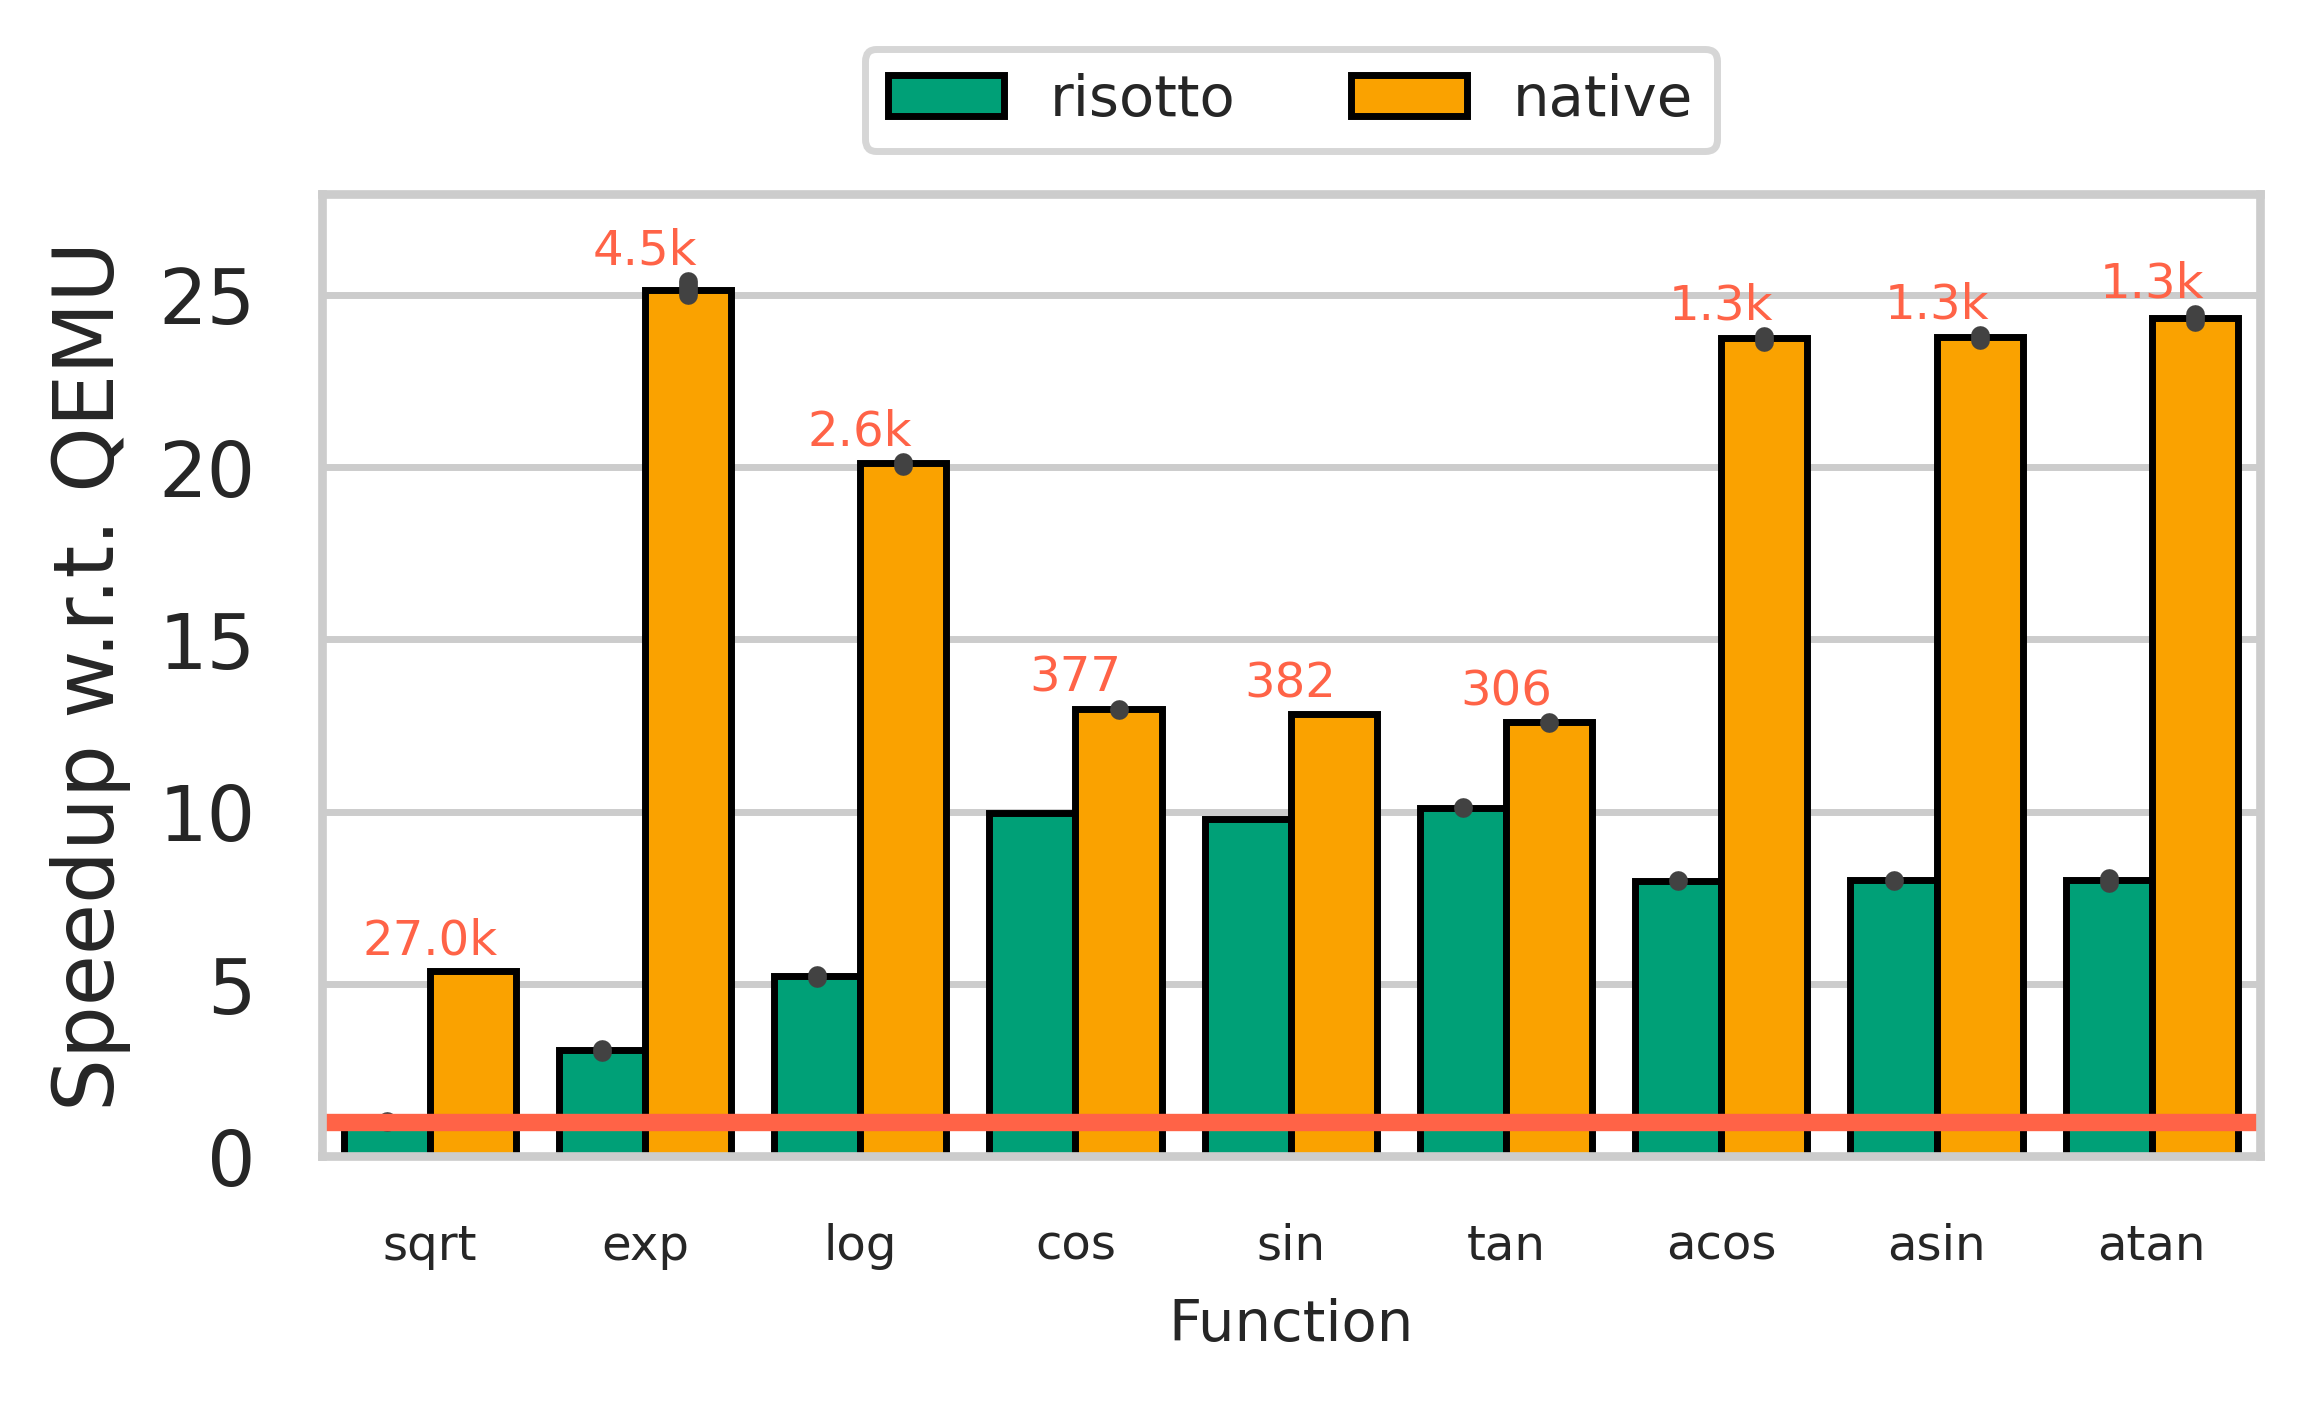

In [9]:
fig = plt.figure(figsize=(5,2.5), dpi=500)
sbs.set(style="whitegrid")
palette = {
    'orange': '#faa200',
    'sky blue': '#00b7ec',
    'bluish green': '#00a077',
    'yellow': '#f5e636',
    'blue': '#0077b8',
    'vermillion': '#f3640d',
    'reddish purple': '#e47ead'
}
order = [ 'sqrt', 'exp', 'log', 'cos', 'sin', 'tan', 'acos', 'asin', 'atan' ]
ax = sbs.barplot(data=df_norm, x='bench', y='norm', hue='label',
                 hue_order=['risotto', 'native'], order=order)
plt.grid(visible=True, axis='y')
plt.xticks(rotation=0, ha="center", fontsize='xx-small')
plt.xlabel("Function", fontsize='x-small')
plt.ylabel("Speedup w.r.t. QEMU")
max_val = max(df_norm['norm'].values)
plt.ylim(0, max_val*1.1)
plt.axhline(y=1, xmin=0, xmax=1, color='tomato', linewidth=2.5)
# Annotate the raw value of the baseline
for idx, value in enumerate(order):
    bm = base_means[f"micro.math-{value}"]
    if bm > 1000000:
        v = f"{bm / 1000000:.0f}M"
    elif bm > 1000:
        v = f"{bm / 1000:.1f}k"
    else:
        v = f"{bm:.0f}"
    #tmp = max(mean_df.loc[mean_df['bench'] == value].values[0][1:]) / base_means[value]
    tmp = max(df_norm.loc[df_norm['bench'] == value]['norm'].values)
    plt.text(idx, tmp+.5, f"{v}", fontsize='xx-small', color='tomato', ha='center')
#plt.vlines(range(0, len(order)), ymin=0, ymax=max_val, linestyle='dashed', colors='grey', linewidth=.25, zorder=0)

# Set color + hatch
style = {
    'fill': [ True, True ],
    'color': [ palette['bluish green'], palette['orange'] ],
    'hatch': [ '', '', ''],
    'edgecolor': [ 'black', 'black', 'black' ]
}
for idx, bar in enumerate(ax.patches):
    bar_nr = int(idx / int(len(order)))
    bar.set(color=style['color'][bar_nr], fill=style['fill'][bar_nr],
            hatch=style['hatch'][bar_nr], edgecolor=style['edgecolor'][bar_nr])

plt.legend(loc='upper center', bbox_to_anchor=(.5, 1.15), borderaxespad=0, ncol=2, fontsize='x-small')

In [10]:
fig.savefig("fig14.pdf", dpi=500, bbox_inches='tight')

In [11]:
for i in sorted_nicely(base_means):
    print(f"{i:25}: {base_means[i]:>20.1f}")

micro.math-acos          :               1283.4
micro.math-asin          :               1282.5
micro.math-atan          :               1254.2
micro.math-cos           :                377.1
micro.math-exp           :               4507.5
micro.math-log           :               2585.9
micro.math-sin           :                382.2
micro.math-sqrt          :              26982.3
micro.math-tan           :                305.9


In [12]:
print(f"bench{20*' '}    risotto     native")
for b in sorted_nicely(base_means):
    ris = df_norm.loc[(df_norm['bench'] == b[11:]) & (df_norm['tag'] == 'risotto')]
    nat = df_norm.loc[(df_norm['bench'] == b[11:]) & (df_norm['tag'] == 'native')]
    print(f"{b:25} {np.mean(ris['norm'].values):>10.4f} {np.mean(nat['norm'].values):>10.2f}")

bench                        risotto     native
micro.math-acos               7.9996      23.75
micro.math-asin               8.0116      23.78
micro.math-atan               8.0119      24.33
micro.math-cos                9.9575      12.98
micro.math-exp                3.0709      25.14
micro.math-log                5.2259      20.11
micro.math-sin                9.7773      12.83
micro.math-sqrt               1.0081       5.38
micro.math-tan               10.1196      12.60
